In [1]:
!pip install shap

     |████████████████████████████████| 564 kB 5.2 MB/s 


# Data Importing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import shap

In [ ]:
oj=pd.read_csv('/content/OJ.csv')
wage=pd.read_csv('/content/Wage.csv')

In [ ]:
oj.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [ ]:
wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


# Data Preprocessing

In [ ]:
oj.dtypes

Purchase           object
WeekofPurchase      int64
StoreID             int64
PriceCH           float64
PriceMM           float64
DiscCH            float64
DiscMM            float64
SpecialCH           int64
SpecialMM           int64
LoyalCH           float64
SalePriceMM       float64
SalePriceCH       float64
PriceDiff         float64
Store7             object
PctDiscMM         float64
PctDiscCH         float64
ListPriceDiff     float64
STORE               int64
dtype: object

In [ ]:
wage.dtypes

year            int64
age             int64
maritl         object
race           object
education      object
region         object
jobclass       object
health         object
health_ins     object
logwage       float64
wage          float64
dtype: object

In [ ]:
oj.isnull().sum()

Purchase          0
WeekofPurchase    0
StoreID           0
PriceCH           0
PriceMM           0
DiscCH            0
DiscMM            0
SpecialCH         0
SpecialMM         0
LoyalCH           0
SalePriceMM       0
SalePriceCH       0
PriceDiff         0
Store7            0
PctDiscMM         0
PctDiscCH         0
ListPriceDiff     0
STORE             0
dtype: int64

In [ ]:
wage.isnull().sum()

year          0
age           0
maritl        0
race          0
education     0
region        0
jobclass      0
health        0
health_ins    0
logwage       0
wage          0
dtype: int64

In [ ]:
oj['Purchase'].value_counts()

CH    653
MM    417
Name: Purchase, dtype: int64

In [ ]:
oj['Store7'].value_counts()

No     714
Yes    356
Name: Store7, dtype: int64

In [ ]:
wage['maritl'].value_counts()

2. Married          2074
1. Never Married     648
4. Divorced          204
5. Separated          55
3. Widowed            19
Name: maritl, dtype: int64

In [ ]:
wage['race'].value_counts()

1. White    2480
2. Black     293
3. Asian     190
4. Other      37
Name: race, dtype: int64

In [ ]:
wage['education'].value_counts()

2. HS Grad            971
4. College Grad       685
3. Some College       650
5. Advanced Degree    426
1. < HS Grad          268
Name: education, dtype: int64

In [ ]:
wage['region'].value_counts()

2. Middle Atlantic    3000
Name: region, dtype: int64

In [ ]:
wage['jobclass'].value_counts()

1. Industrial     1544
2. Information    1456
Name: jobclass, dtype: int64

In [ ]:
wage['health'].value_counts()

2. >=Very Good    2142
1. <=Good          858
Name: health, dtype: int64

In [ ]:
wage['health_ins'].value_counts()

1. Yes    2083
2. No      917
Name: health_ins, dtype: int64

In [ ]:
oj_dmy=pd.get_dummies(oj)
oj_dmy=oj_dmy.drop(['Purchase_MM','Store7_No'],axis=1)
oj.dmy=oj_dmy.rename(columns={'Purchase_CH':'Purchase'},inplace=True) #CH=1, MM=0
oj_dmy

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE,Purchase,Store7_Yes
0,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,1.99,1.75,0.24,0.000000,0.000000,0.24,1,1,0
1,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,1.69,1.75,-0.06,0.150754,0.000000,0.24,1,1,0
2,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,2.09,1.69,0.40,0.000000,0.091398,0.23,1,1,0
3,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,1.69,1.69,0.00,0.000000,0.000000,0.00,1,0,0
4,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,1.69,1.69,0.00,0.000000,0.000000,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,2.09,1.76,0.33,0.000000,0.053763,0.23,0,1,1
1066,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,2.18,1.86,0.32,0.000000,0.000000,0.32,0,1,1
1067,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,2.18,1.86,0.32,0.000000,0.000000,0.32,0,0,1
1068,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,1.89,1.86,0.03,0.112676,0.000000,0.27,0,1,1


In [ ]:
wage=wage.drop(['region','logwage'],axis=1)

In [ ]:
wage_dmy=pd.get_dummies(wage)
wage_dmy.head()

,year,age,wage,maritl_1. Never Married,maritl_2. Married,maritl_3. Widowed,maritl_4. Divorced,maritl_5. Separated,race_1. White,race_2. Black,...,education_2. HS Grad,education_3. Some College,education_4. College Grad,education_5. Advanced Degree,jobclass_1. Industrial,jobclass_2. Information,health_1. <=Good,health_2. >=Very Good,health_ins_1. Yes,health_ins_2. No
0,2006,18,75.043154,1,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,1
1,2004,24,70.476020,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,1,0,1
2,2003,45,130.982177,0,1,0,0,0,1,0,...,0,1,0,0,1,0,1,0,1,0
3,2003,43,154.685293,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,1,0
4,2005,50,75.043154,0,0,0,1,0,1,0,...,1,0,0,0,0,1,1,0,1,0


In [ ]:
wage_dmy=wage_dmy.drop(['maritl_1. Never Married','race_1. White','education_1. < HS Grad','health_2. >=Very Good','health_ins_2. No','jobclass_2. Information'],axis=1)
wage_dmy

,year,age,wage,maritl_2. Married,maritl_3. Widowed,maritl_4. Divorced,maritl_5. Separated,race_2. Black,race_3. Asian,race_4. Other,education_2. HS Grad,education_3. Some College,education_4. College Grad,education_5. Advanced Degree,jobclass_1. Industrial,health_1. <=Good,health_ins_1. Yes
0,2006,18,75.043154,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,2004,24,70.476020,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2003,45,130.982177,1,0,0,0,0,0,0,0,1,0,0,1,1,1
3,2003,43,154.685293,1,0,0,0,0,1,0,0,0,1,0,0,0,1
4,2005,50,75.043154,0,0,1,0,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,154.685293,1,0,0,0,0,0,0,0,1,0,0,1,0,1
2996,2007,30,99.689464,1,0,0,0,0,0,0,1,0,0,0,1,0,0
2997,2005,27,66.229408,1,0,0,0,1,0,0,0,0,0,0,1,1,0
2998,2005,27,87.981033,0,0,0,0,0,0,0,0,1,0,0,1,0,1


In [ ]:
oj_dmy.to_csv('OJ Preprocessed.csv',index=False)
wage_dmy.to_csv('Wage Preprocessed.csv',index=False)

In [3]:
oj_dmy=pd.read_csv('/content/OJ Preprocessed.csv')
wage_dmy=pd.read_csv('/content/Wage Preprocessed.csv')

In [4]:
X_oj=oj_dmy.drop(['Purchase'],axis=1)
Y_oj=oj_dmy['Purchase']
X_wage=wage_dmy.drop(['wage'],axis=1)
Y_wage=wage_dmy['wage']

In [5]:
#Untuk Data Regresi (Wage)
X_trainr,X_testr,Y_trainr,Y_testr=train_test_split(X_wage,Y_wage,test_size=0.3)

In [6]:
#Untuk Data Klasifikasi (OJ)
X_trainc,X_testc,Y_trainc,Y_testc=train_test_split(X_oj,Y_oj,test_size=0.3)

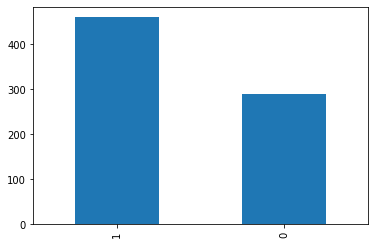

In [ ]:
Y_trainc.value_counts().plot(kind='bar')

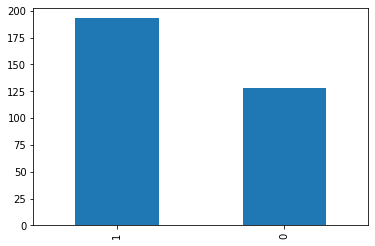

In [ ]:
Y_testc.value_counts().plot(kind='bar')

In [ ]:
print(X_trainr.shape)
print(X_testr.shape)
print(Y_trainr.shape)
print(Y_testr.shape)

(2100, 16)
(900, 16)
(2100,)
(900,)


In [ ]:
print(X_trainc.shape)
print(X_testc.shape)
print(Y_trainc.shape)
print(Y_testc.shape)

(749, 17)
(321, 17)
(749,)
(321,)


In [7]:
np.random.seed(123)

# Modelling

## Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
clf1=DecisionTreeClassifier(criterion='entropy') #Information Gain
clf1.fit(X_trainc,Y_trainc)

DecisionTreeClassifier(criterion='entropy')

[Text(0.48305555555555557, 0.9761904761904762, 'X[8] <= 0.483\nentropy = 0.962\nsamples = 749\nvalue = [289, 460]'),
 Text(0.13375, 0.9285714285714286, 'X[8] <= 0.036\nentropy = 0.799\nsamples = 285\nvalue = [216, 69]'),
 Text(0.06666666666666667, 0.8809523809523809, 'X[1] <= 2.5\nentropy = 0.135\nsamples = 53\nvalue = [52, 1]'),
 Text(0.057777777777777775, 0.8333333333333334, 'X[8] <= 0.003\nentropy = 0.414\nsamples = 12\nvalue = [11, 1]'),
 Text(0.04888888888888889, 0.7857142857142857, 'X[8] <= 0.001\nentropy = 0.811\nsamples = 4\nvalue = [3, 1]'),
 Text(0.04, 0.7380952380952381, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.057777777777777775, 0.7380952380952381, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.06666666666666667, 0.7857142857142857, 'entropy = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.07555555555555556, 0.8333333333333334, 'entropy = 0.0\nsamples = 41\nvalue = [41, 0]'),
 Text(0.20083333333333334, 0.8809523809523809, 'X[8] <= 0.275\nentropy = 0.873\

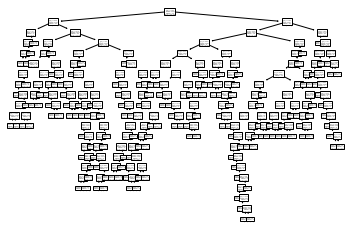

In [ ]:
plot_tree(clf1)

In [ ]:
Y_pred=clf1.predict(X_testc)
print(classification_report(Y_testc,Y_pred))

              precision    recall  f1-score   support

           0       0.73      0.64      0.68       128
           1       0.78      0.84      0.81       193

    accuracy                           0.76       321
   macro avg       0.76      0.74      0.75       321
weighted avg       0.76      0.76      0.76       321



In [ ]:
clf2=DecisionTreeClassifier(criterion='gini') #Gini Index
clf2.fit(X_trainc,Y_trainc)

DecisionTreeClassifier()

[Text(0.46047794117647056, 0.9791666666666666, 'X[8] <= 0.482\ngini = 0.48\nsamples = 749\nvalue = [299, 450]'),
 Text(0.16337316176470587, 0.9375, 'X[8] <= 0.137\ngini = 0.334\nsamples = 278\nvalue = [219, 59]'),
 Text(0.04411764705882353, 0.8958333333333334, 'X[15] <= 3.5\ngini = 0.099\nsamples = 96\nvalue = [91, 5]'),
 Text(0.03676470588235294, 0.8541666666666666, 'X[0] <= 228.0\ngini = 0.081\nsamples = 95\nvalue = [91, 4]'),
 Text(0.014705882352941176, 0.8125, 'X[3] <= 1.74\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.007352941176470588, 0.7708333333333334, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.022058823529411766, 0.7708333333333334, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.058823529411764705, 0.8125, 'X[1] <= 2.5\ngini = 0.062\nsamples = 93\nvalue = [90, 3]'),
 Text(0.03676470588235294, 0.7708333333333334, 'X[10] <= 1.81\ngini = 0.153\nsamples = 24\nvalue = [22, 2]'),
 Text(0.029411764705882353, 0.7291666666666666, 'gini = 0.0\nsamples = 14\nvalue =

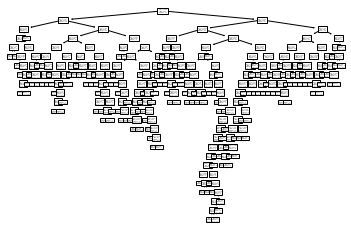

In [ ]:
plot_tree(clf2)

In [ ]:
Y_pred=clf2.predict(X_testc)
print(classification_report(Y_testc,Y_pred))

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       128
           1       0.78      0.85      0.81       193

    accuracy                           0.77       321
   macro avg       0.76      0.75      0.75       321
weighted avg       0.76      0.77      0.76       321



In [ ]:
#Post Pruning
clf=DecisionTreeClassifier()
path=clf.cost_complexity_pruning_path(X_trainc, Y_trainc)
ccp_alphas, impurities=path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

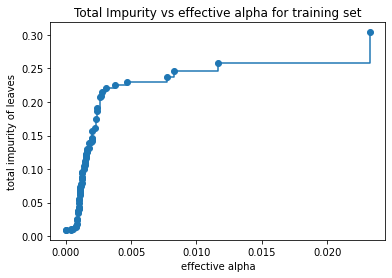

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_trainc, Y_trainc)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1700404902533066


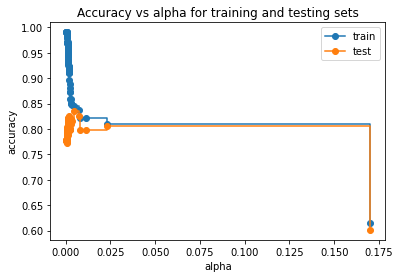

In [ ]:
train_scores = [clf.score(X_trainc, Y_trainc) for clf in clfs]
test_scores = [clf.score(X_testc, Y_testc) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
clf2_1=DecisionTreeClassifier(criterion='gini',ccp_alpha=0.005) #Gini Index
clf2_1.fit(X_trainc,Y_trainc)

DecisionTreeClassifier(ccp_alpha=0.005)

In [ ]:
Y_pred=clf2_1.predict(X_testc)
print(classification_report(Y_testc,Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.72      0.78       128
           1       0.83      0.91      0.87       193

    accuracy                           0.83       321
   macro avg       0.84      0.82      0.82       321
weighted avg       0.84      0.83      0.83       321



In [ ]:
clf3=DecisionTreeRegressor(criterion='squared_error') #MSE
clf3.fit(X_trainr,Y_trainr)

DecisionTreeRegressor()

[Text(0.616971574391262, 0.98, 'X[12] <= 0.5\nsquared_error = 1699.345\nsamples = 2100\nvalue = 111.155'),
 Text(0.3569552585517689, 0.94, 'X[15] <= 0.5\nsquared_error = 1186.889\nsamples = 1785\nvalue = 104.306'),
 Text(0.14285176679053124, 0.9, 'X[2] <= 0.5\nsquared_error = 917.569\nsamples = 571\nvalue = 87.23'),
 Text(0.051548593907697955, 0.86, 'X[1] <= 23.5\nsquared_error = 467.192\nsamples = 221\nvalue = 75.778'),
 Text(0.013210309814356056, 0.82, 'X[1] <= 19.5\nsquared_error = 296.653\nsamples = 64\nvalue = 64.754'),
 Text(0.0028137137963727557, 0.78, 'X[1] <= 18.5\nsquared_error = 237.145\nsamples = 11\nvalue = 53.188'),
 Text(0.0014680245894118727, 0.74, 'X[14] <= 0.5\nsquared_error = 69.625\nsamples = 3\nvalue = 63.379'),
 Text(0.0009786830596079151, 0.7, 'X[0] <= 2005.0\nsquared_error = 2.402\nsamples = 2\nvalue = 57.547'),
 Text(0.0004893415298039576, 0.66, 'squared_error = 0.0\nsamples = 1\nvalue = 55.997'),
 Text(0.0014680245894118727, 0.66, 'squared_error = 0.0\nsamples

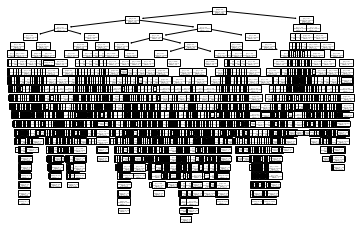

In [ ]:
plot_tree(clf3)

In [ ]:
Y_pred=clf3.predict(X_testr)
print("MSE:",mean_squared_error(Y_testr,Y_pred))
print("MAE:",mean_absolute_error(Y_testr,Y_pred))

MSE: 2006.2107827976545
MAE: 32.0652822066576


Feature: 0, Score: 0.11853
Feature: 1, Score: 0.03259
Feature: 2, Score: 0.01279
Feature: 3, Score: 0.00671
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00287
Feature: 7, Score: 0.00396
Feature: 8, Score: 0.63890
Feature: 9, Score: 0.02874
Feature: 10, Score: 0.01628
Feature: 11, Score: 0.04798
Feature: 12, Score: 0.00319
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.07298
Feature: 15, Score: 0.00621
Feature: 16, Score: 0.00827


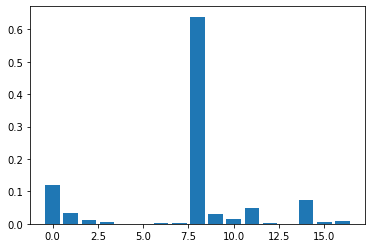

In [ ]:
# get importance
importance = clf2.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: 0.15528
Feature: 1, Score: 0.37071
Feature: 2, Score: 0.03338
Feature: 3, Score: 0.00107
Feature: 4, Score: 0.00909
Feature: 5, Score: 0.00692
Feature: 6, Score: 0.01923
Feature: 7, Score: 0.02363
Feature: 8, Score: 0.00140
Feature: 9, Score: 0.00470
Feature: 10, Score: 0.01794
Feature: 11, Score: 0.06562
Feature: 12, Score: 0.15736
Feature: 13, Score: 0.03896
Feature: 14, Score: 0.04123
Feature: 15, Score: 0.05348


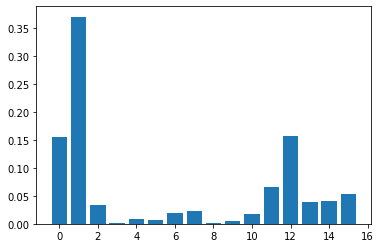

In [ ]:
# get importance
importance = clf3.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

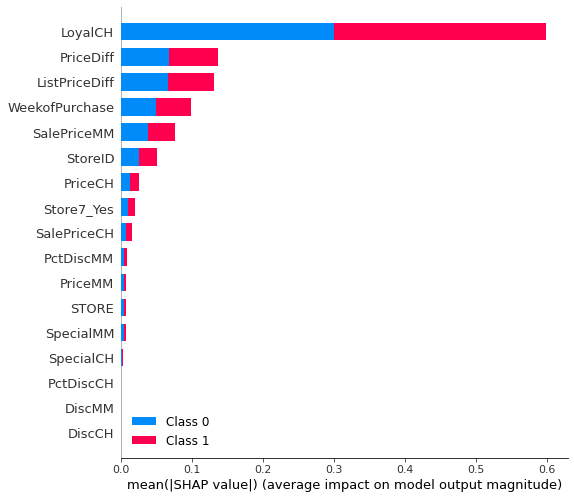

In [ ]:
#SHAP value - Variable Importance
shap_values = shap.TreeExplainer(clf2).shap_values(X_trainc)
shap.summary_plot(shap_values, X_trainc, plot_type="bar")

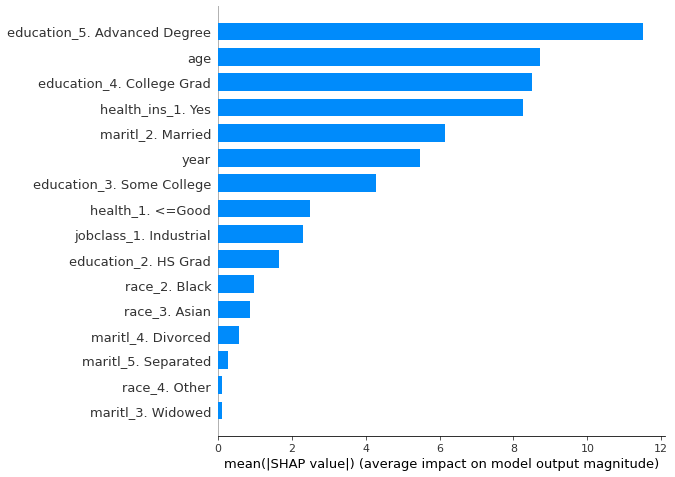

In [ ]:
#SHAP value - Variable Importance
shap_values = shap.TreeExplainer(clf3).shap_values(X_trainr)
shap.summary_plot(shap_values, X_trainr, plot_type="bar")

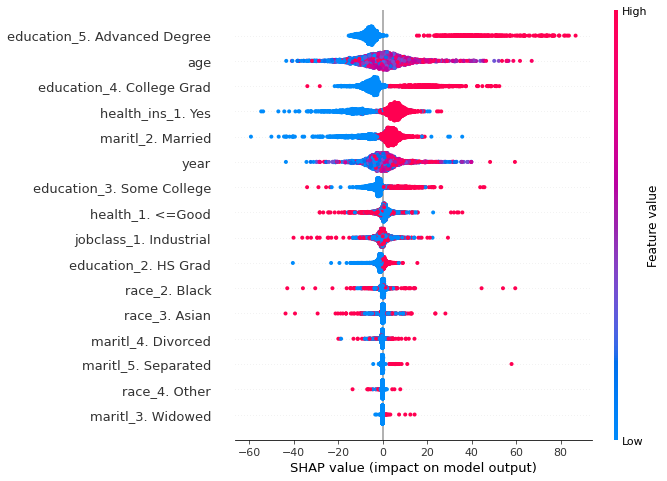

In [ ]:
f = plt.figure()
shap.summary_plot(shap_values, X_trainr)
f.savefig("SHAP_plot_train.png", bbox_inches='tight', dpi=600)

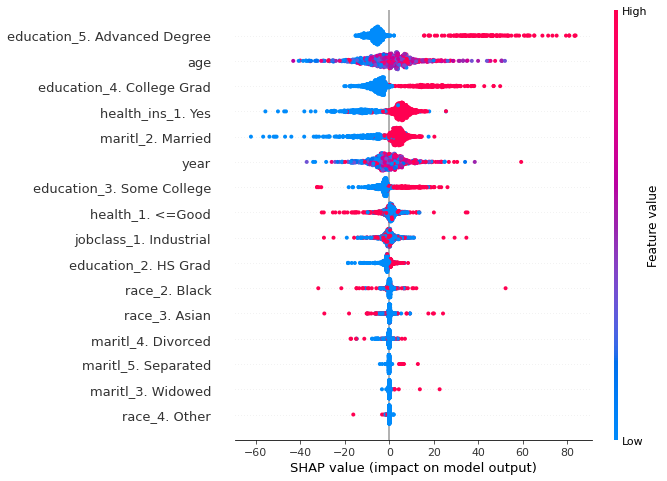

In [ ]:
f = plt.figure()
shap_values = shap.TreeExplainer(clf3).shap_values(X_testr)
shap.summary_plot(shap_values, X_testr)
f.savefig("SHAP_plot_test.png", bbox_inches='tight', dpi=600)

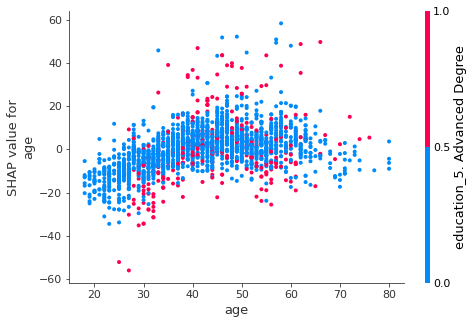

In [ ]:
#SHAP Value - Dependence Plot
shap_values = shap.TreeExplainer(clf3).shap_values(X_trainr)
shap.dependence_plot('age', shap_values, X_trainr)

## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

In [10]:
rf1=RandomForestClassifier()
rf1.fit(X_trainc,Y_trainc)

RandomForestClassifier()

In [11]:
Y_pred=rf1.predict(X_testc)
print(classification_report(Y_testc,Y_pred))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       130
           1       0.82      0.85      0.84       191

    accuracy                           0.80       321
   macro avg       0.80      0.79      0.79       321
weighted avg       0.80      0.80      0.80       321



In [12]:
#Cross Validation
rf1a=RandomForestClassifier()
cv=StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
n_scores = cross_val_score(rf1a, X_oj, Y_oj, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')

In [13]:
n_scores

array([0.79389313, 0.82706767, 0.765625  , 0.83687943, 0.85271318,
       0.8372093 , 0.816     , 0.81751825, 0.84671533, 0.8503937 ])

In [14]:
print('F1-score: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

F1-score: 0.824 (0.026)


In [22]:
params={'n_estimators':(100,200,400,800),'max_features':('auto',16//3)}
rf1b=RandomForestClassifier()
gs=GridSearchCV(rf1b,params)
gs.fit(X_trainc,Y_trainc)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ('auto', 5),
                         'n_estimators': (100, 200, 400, 800)})

In [23]:
gs.cv_results_

{'mean_fit_time': array([0.26608968, 0.39898462, 0.78436804, 1.55949497, 0.20267673,
        0.40070581, 0.79512386, 1.58761311]),
 'mean_score_time': array([0.02417378, 0.03466001, 0.0723258 , 0.13517332, 0.01818542,
        0.0374929 , 0.07371678, 0.13023968]),
 'mean_test_score': array([0.80235347, 0.80636242, 0.81037136, 0.8036868 , 0.80636242,
        0.80235347, 0.80635347, 0.81037136]),
 'param_max_features': masked_array(data=['auto', 'auto', 'auto', 'auto', 5, 5, 5, 5],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 200, 400, 800, 100, 200, 400, 800],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_features': 'auto', 'n_estimators': 100},
  {'max_features': 'auto', 'n_estimators': 200},
  {'max_features': 'auto', 'n_estimators': 400},
  {'max_features':

In [24]:
gs.best_estimator_

RandomForestClassifier(n_estimators=400)

In [25]:
rf1c=RandomForestClassifier(n_estimators=400)
rf1c.fit(X_trainc,Y_trainc)

RandomForestClassifier(n_estimators=400)

In [26]:
Y_pred=rf1c.predict(X_testc)
print(classification_report(Y_testc,Y_pred))

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       130
           1       0.81      0.84      0.82       191

    accuracy                           0.79       321
   macro avg       0.78      0.78      0.78       321
weighted avg       0.79      0.79      0.79       321



In [15]:
rf2=RandomForestRegressor(max_features=16//3)
rf2.fit(X_trainr,Y_trainr)

RandomForestRegressor(max_features=5)

In [16]:
Y_pred=rf2.predict(X_testr)
print("MSE:",mean_squared_error(Y_testr,Y_pred))
print("MAE:",mean_absolute_error(Y_testr,Y_pred))

MSE: 1314.4142474335142
MAE: 25.2872728812593


In [17]:
params={'n_estimators':(100,200,400),'max_features':('auto',16//3)}
rf2a=RandomForestRegressor()
gs=GridSearchCV(rf2a,params)
gs.fit(X_trainr,Y_trainr)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_features': ('auto', 5),
                         'n_estimators': (100, 200, 400)})

In [18]:
gs.cv_results_

{'mean_fit_time': array([0.47677307, 0.87599707, 1.73365855, 0.28807812, 0.566785  ,
        1.13581867]),
 'mean_score_time': array([0.02656794, 0.04538169, 0.08355112, 0.02306476, 0.04387832,
        0.08337569]),
 'mean_test_score': array([0.21010231, 0.21167914, 0.2175353 , 0.24102985, 0.24760548,
        0.2460585 ]),
 'param_max_features': masked_array(data=['auto', 'auto', 'auto', 5, 5, 5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 200, 400, 100, 200, 400],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_features': 'auto', 'n_estimators': 100},
  {'max_features': 'auto', 'n_estimators': 200},
  {'max_features': 'auto', 'n_estimators': 400},
  {'max_features': 5, 'n_estimators': 100},
  {'max_features': 5, 'n_estimators': 200},
  {'max_features': 5, 'n_estimators': 400}],
 'rank

In [19]:
gs.best_estimator_

RandomForestRegressor(max_features=5, n_estimators=200)

In [20]:
rf2b=RandomForestRegressor(max_features=5, n_estimators=200)
rf2b.fit(X_trainr,Y_trainr)

RandomForestRegressor(max_features=5, n_estimators=200)

In [21]:
Y_pred=rf2b.predict(X_testr)
print("MSE:",mean_squared_error(Y_testr,Y_pred))
print("MAE:",mean_absolute_error(Y_testr,Y_pred))

MSE: 1299.197616834107
MAE: 25.150311149047525
